In [14]:
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler

In [15]:
colour_gradient_map = {
    "red": [
        "#fee6ce", "#fdae61", "#f46d43", "#d73027", "#a50026"
    ],
    "pink": [
        "#fde0dd", "#fa9fb5", "#f768a1", "#dd3497", "#7a0177"
    ],
    "purple": [
        "#f2f0f7", "#cbc9e2", "#9e9ac8", "#756bb1", "#54278f"
    ],
    "blue": [
        "#b3cde3", "#6497b1", "#005b96", "#03396c", "#011f4b"
    ],
    "green": [
        "#c7e9b4", "#7fc97f", "#4d8f4c", "#2b6138", "#00441b"
    ],
    "yellow": [
        "#ffffcc", "#ffeda0", "#fed976", "#feb24c", "#fd8d3c"
    ]
}

In [16]:
def get_graph_weights_colours(graph_path, idx):    
    # Load the graph and normalize weights
    G = nx.read_gexf(graph_path)

    # Extract original weights and normalize them
    weights = [data["weight"] for _, data in G.nodes(data=True)]
    scaler = MinMaxScaler()
    normalized_weights = scaler.fit_transform([[w] for w in weights]).flatten()

    # Assign normalized weights back to the graph
    for i, (node, data) in enumerate(G.nodes(data=True)):
        data["normalized_weight"] = normalized_weights[i]

    # Extract node information for word cloud
    hashtag_weights = {node: data["weight"] for node, data in G.nodes(data=True)}
    normalized_weights_dict = {node: data["normalized_weight"] for node, data in G.nodes(data=True)}

    # Define a color map for the word cloud
    colour = list(colour_gradient_map.keys())[idx]
    colour_map = mcolors.LinearSegmentedColormap.from_list(colour+"_gradient", colour_gradient_map[colour])

    return hashtag_weights, normalized_weights_dict, weights, colour_map

def color_func(word, colour_map, font_size, position, orientation, random_state=None, normalized_weight=None, **kwargs): 
    # Reverse the normalized weight for the color gradient
    normalized_weight = 1 - normalized_weight  # Reverse the gradient 

    # Map the normalized weight to a color using the colormap
    rgba_colour = colour_map(normalized_weight)
    
    # Convert RGBA to RGB tuple scaled to 0-255 and return as PIL-compatible color
    rgb_colour = tuple(int(255 * c) for c in rgba_colour[:3])
    return rgb_colour

def create_wordcloud(hashtag_weights, normalized_weights, weights, colour_map, idx, saved_as="word_cloud"):
    """
    Create a word cloud with colors based on normalized weights.

    Args:
        hashtag_weights: Dictionary of hashtags and their frequency.
        normalized_weights: Dictionary of normalized weights (keyed by word).
        color_map: A colormap for the gradient.
        idx: Index used to determine color flow.
    """
    # Generate the WordCloud with original weights for size and reversed normalized weights for color
    wordcloud = WordCloud(
        width=800, height=400,
        background_color="white",
        color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs: color_func(word, colour_map, font_size, position, orientation, random_state, normalized_weights.get(word, 0), **kwargs),
        max_words=200
    ).generate_from_frequencies(hashtag_weights)
    
    # Plot the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Hashtag Word Cloud for Week {idx+1} with Colour Gradient by Node Weight (i.e. frequency)")

    # Create a color bar as the legend
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    sm = plt.cm.ScalarMappable(cmap=colour_map.reversed(), norm=norm)  # Reverse color bar to match the reversed gradient
    sm.set_array([])

    # Add color bar with original weight mapping
    cbar = plt.colorbar(sm, orientation="horizontal", fraction=0.046, pad=0.04)
    cbar.set_label("Frequency of use of Hashtag by colour")
    plt.savefig(f'wordClouds/{saved_as}_{idx+1}.png', dpi=300)
    plt.show()


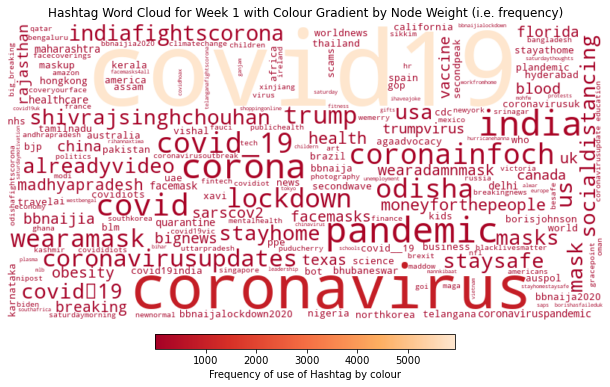

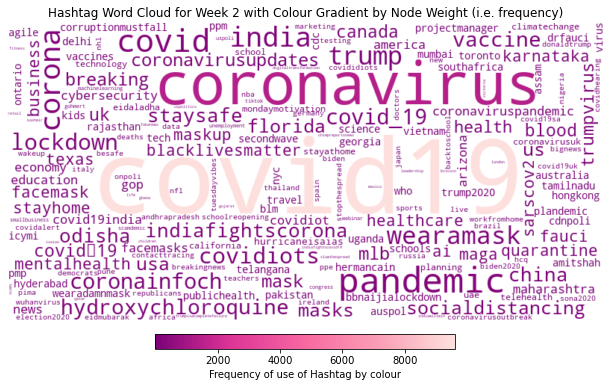

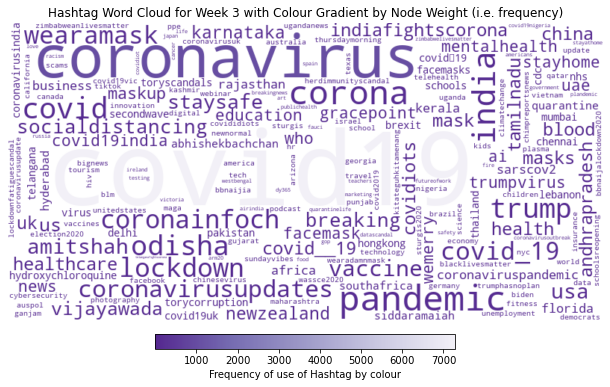

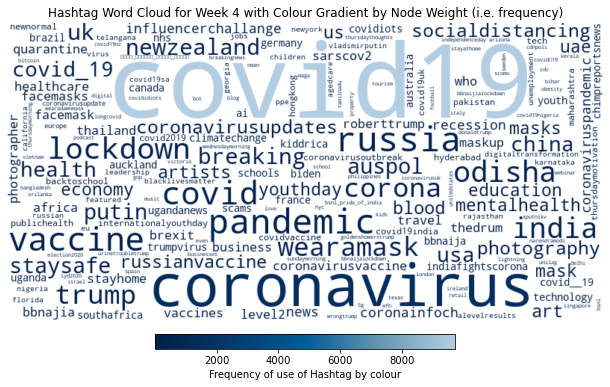

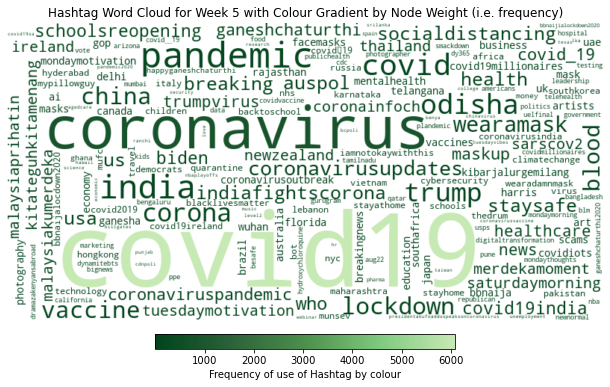

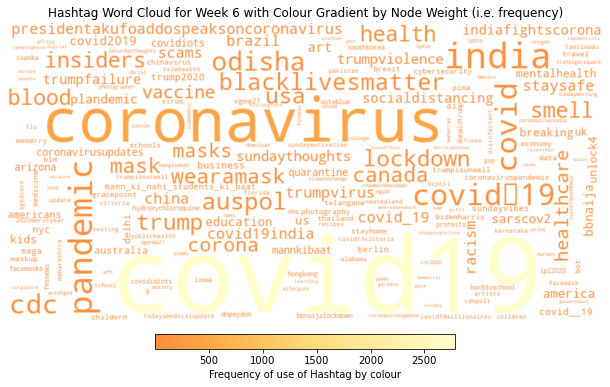

In [17]:
all_hashtag_weights = []
for idx in range(6):
    hashtag_weights, normalized_weights_dict, weights, colour_map = get_graph_weights_colours(f"graphs/week_{idx+1}.gexf", idx)
    all_hashtag_weights.append(hashtag_weights)
    create_wordcloud(hashtag_weights, normalized_weights_dict, weights, colour_map, idx)
    

## Now, because all the word clouds look very similar at first glance due to common hashtags, we can analyse the trends better over the 6 weeks by removing these overlapping words

In [18]:
def remove_common_hashtags(all_hashtag_weights):
 # Find common hashtags across all graphs
    all_hashtags = [set(hashtags.keys()) for hashtags in all_hashtag_weights]
    common_hashtags = set.intersection(*all_hashtags)
    
    # Remove common hashtags from each graph's hashtag weights
    filtered_hashtag_weights = []
    for hashtag_weights in all_hashtag_weights:
        filtered_hashtag_weights.append({k: v for k, v in hashtag_weights.items() if k not in common_hashtags})

    return filtered_hashtag_weights

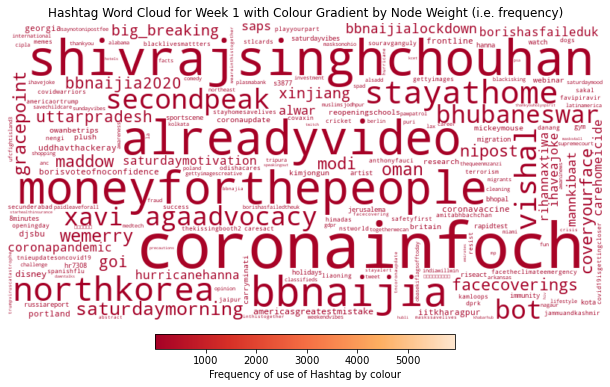

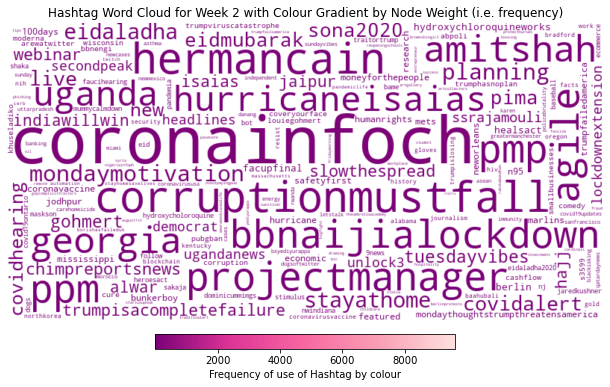

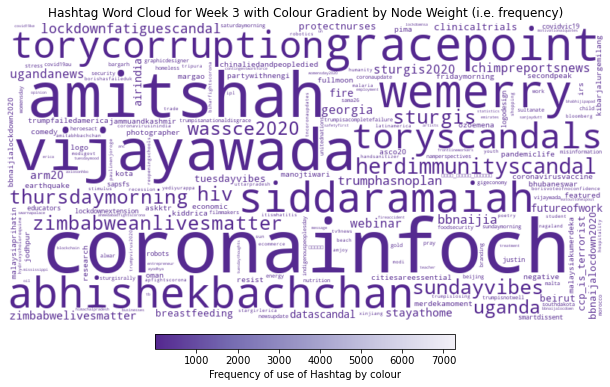

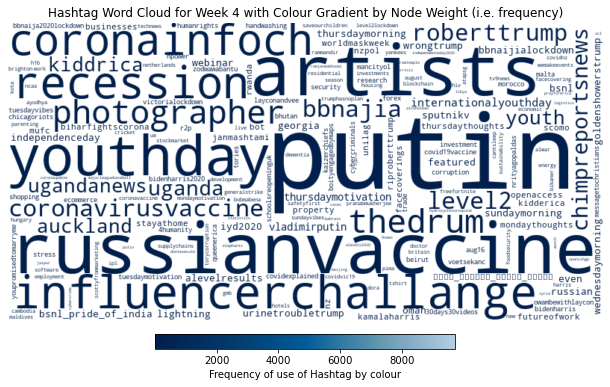

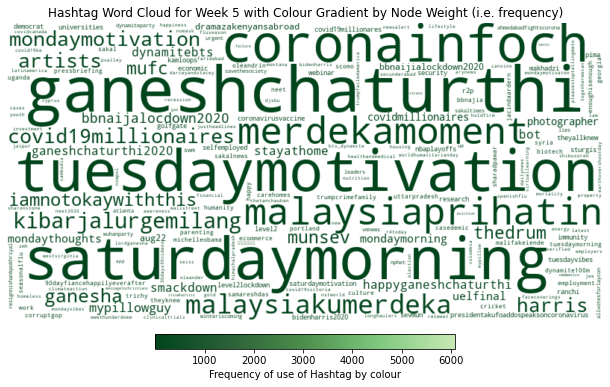

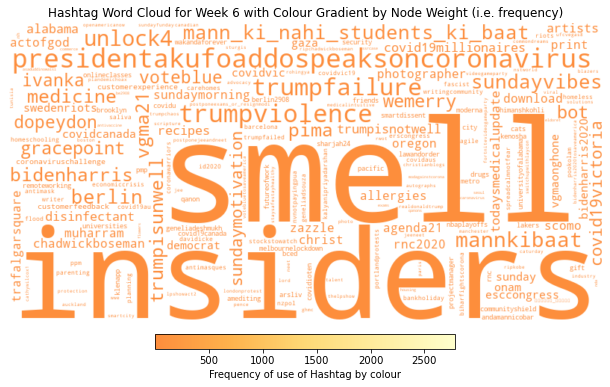

In [19]:
# Remove common hashtags
filtered_hashtag_weights = remove_common_hashtags(all_hashtag_weights)

# Now create word clouds for each week without common hashtags
for idx, hashtag_weights in enumerate(filtered_hashtag_weights):
    _, normalized_weights_dict, weights, colour_map = get_graph_weights_colours(f"graphs/week_{idx+1}.gexf", idx)
    create_wordcloud(hashtag_weights, normalized_weights_dict, weights, colour_map, idx, saved_as="uncommon_word_cloud")